In [24]:
import os
import numpy as np
from PIL import Image
from pprint import pprint

def load_images(folder):
    imgs = []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("L")
        imgs.append(np.array(img, dtype=np.float32))
    return imgs

def extract_blocks(img, block=8):
    H, W = img.shape
    blocks = []
    for i in range(0, H, block):
        for j in range(0, W, block):
            b = img[i:i+block, j:j+block]
            if b.shape == (block, block):
                blocks.append(b.reshape(-1))
    return np.array(blocks)


train_images = load_images("TrainSet")
test_images  = load_images("TestSet")

train_blocks = np.concatenate([extract_blocks(img) for img in train_images]) / 255.0
test_blocks  = np.concatenate([extract_blocks(img) for img in test_images])  / 255.0

print("TRAIN BLOCK")
print(f"train block 0: {len(train_blocks[0])}")
pprint(train_blocks[0])
print("\nTEST BLOCK")
pprint(test_blocks[0])
print(f"test block 0: {len(test_blocks[0])}")



TRAIN BLOCK
train block 0: 64
array([0.9764706 , 0.9764706 , 0.98039216, 0.9843137 , 0.9882353 ,
       0.99607843, 0.99607843, 1.        , 0.9764706 , 0.9764706 ,
       0.98039216, 0.9843137 , 0.9882353 , 0.99215686, 0.99607843,
       1.        , 0.9764706 , 0.98039216, 0.98039216, 0.9843137 ,
       0.9882353 , 0.99215686, 0.99607843, 0.99607843, 0.98039216,
       0.98039216, 0.9843137 , 0.9843137 , 0.9882353 , 0.99215686,
       0.99215686, 0.99215686, 0.9843137 , 0.9843137 , 0.9843137 ,
       0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 , 0.99215686,
       0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 ,
       0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 ,
       0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9843137 ,
       0.9843137 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 ,
       0.9882353 , 0.9843137 , 0.9843137 , 0.9843137 ], dtype=float32)

TEST BLOCK
array([0.6       , 0.5921569 , 0.59607846, 0.5921569 , 0.59607846,
       0.6039216

In [25]:
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)


In [38]:
# Python Code Snippet (prepare_data_by_block)

def prepare_data_by_block(images_list, block_size):
    """Loads and extracts blocks for a given block size."""
    # Concatenate all blocks from all images in the list
    # Reusing the extract_blocks function defined earlier
    all_blocks = [extract_blocks(img, block=block_size) for img in images_list]
    
    # Normalize and return
    return np.concatenate(all_blocks) / 255.0

In [26]:
def MSE(X, Y):
    return np.mean((X - Y)**2)

def PSNR(mse):
    return 10 * np.log10(1 / mse)

In [42]:
class MLP_Autoencoder_Improved:
    
    # MODIFIED: Added use_momentum flag with default=True
    def __init__(self, input_dim=64, hidden_dim=16, use_momentum=True, beta=0.9):
        
        # ... (W1, b1, W2, b2 initialization remains the same)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2/input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2/hidden_dim)
        self.b2 = np.zeros((1, input_dim))
        # ... (vW, vb initialization remains the same)

        # MODIFIED: Momentum States and Flag
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        
        # If use_momentum is False, set beta to 0, which effectively turns off momentum.
        self.beta = beta if use_momentum else 0.0 
        self.use_momentum = use_momentum # For tracking in the report
        
    def forward(self, X):
        # ... (Forward pass remains the same)
        self.X = X
        
        # 1. Forward Pass Layer 1 (Encoder)
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        
        # 2. Forward Pass Layer 2 (Decoder) - Z2 MUST be calculated here!
        self.z2 = self.a1 @ self.W2 + self.b2 # 👈 مطمئن شوید این خط وجود دارد و درست است
        
        # 3. Output
        self.a2 = sigmoid(self.z2)
        return self.a2
    
    # MODIFIED: Cleaned up momentum logic in backward
    def backward(self, lr=0.05):
        m = self.X.shape[0]

        # ... (Gradient calculation dW1, db1, dW2, db2 remains the same)
        # Assuming you implemented the 2* factor for MSE derivative if needed, 
        # or absorbed it into the learning rate.
        dz2 = (self.a2 - self.X) * sigmoid_deriv(self.z2)
        dW2 = self.a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # ... (dZ1, dW1, db1 calculation remains the same)
        dz1 = (dz2 @ self.W2.T) * relu_deriv(self.z1)
        dW1 = self.X.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Momentum Updates (Standard Heavy-Ball Logic)
        # If self.beta=0, then vW2 = dW2 (standard SGD update)
        self.vW2 = self.beta * self.vW2 + dW2
        self.vb2 = self.beta * self.vb2 + db2
        self.vW1 = self.beta * self.vW1 + dW1
        self.vb1 = self.beta * self.vb1 + db1

        # Weight Update (uses the calculated velocity 'v')
        self.W2 -= lr * self.vW2
        self.b2 -= lr * self.vb2
        self.W1 -= lr * self.vW1
        self.b1 -= lr * self.vb1

In [28]:
def train_autoencoder_minibatch(model, X_train, X_test, epochs=80, lr=0.005, batch_size=64):
    
    # 1. Initialization of return variables (NEW)
    avg_loss_list = []
    test_psnr_list = []
    
    data_size = X_train.shape[0]
    indices = np.arange(data_size)
    
    for ep in range(epochs):
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        
        epoch_loss = 0
        num_batches = 0
        
        for i in range(0, data_size, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            
            out_batch = model.forward(X_batch)
            loss_batch = MSE(out_batch, X_batch)
            model.backward(lr)
            
            epoch_loss += loss_batch
            num_batches += 1
            
        avg_loss = epoch_loss / num_batches
        
        # Calculate Test PSNR 
        out_test = model.forward(X_test)
        mse_test = MSE(out_test, X_test)
        psnr_test = PSNR(mse_test)
        
        # 2. Saving results (NEW)
        avg_loss_list.append(avg_loss)
        test_psnr_list.append(psnr_test)
        
        print(f"Epoch {ep+1}/{epochs} | Avg Train MSE={avg_loss:.6f} | Test PSNR={psnr_test:.2f} dB")

    # 3. Return the lists
    return avg_loss_list, test_psnr_list

In [29]:
def reconstruct_image(model, img):
    blocks = extract_blocks(img, block=8) / 255.0
    out = model.forward(blocks) * 255.0
    out = out.astype(np.uint8)

    H, W = img.shape
    new_img = np.zeros((H, W), dtype=np.uint8)

    bi = 0
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            new_img[i:i+8, j:j+8] = out[bi].reshape(8,8)
            bi += 1

    return new_img


In [48]:
import matplotlib.pyplot as plt
from PIL import Image

# ... (سایر توابع) ...

def show_reconstruction(model, img, block_size):
    """
    Shows image reconstruction using the trained model,
    using the correct block_size corresponding to the model.
    """
    # 1. Extract blocks using the correct size
    blocks = extract_blocks(img, block=block_size) / 255.0 
    
    # 2. Forward pass and denormalize
    out = model.forward(blocks) * 255.0
    out = out.astype(np.uint8)
    
    # 3. Reconstruct image from blocks
    H, W = img.shape
    rec = np.zeros((H, W), dtype=np.uint8)

    k = 0
    # The reconstruction logic should also use block_size
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            # Check if block exists (to handle edges if image size is not divisible)
            if k < len(out):
                 rec[i:i+block_size, j:j+block_size] = out[k].reshape(block_size, block_size)
                 k += 1

    # 4. Display results
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')
    plt.axis(False)

    plt.subplot(1,2,2)
    plt.title(f"Reconstructed (B={block_size} H={model.W1.shape[1]})")
    plt.imshow(rec, cmap='gray')
    plt.axis(False)

    plt.show() # این دستور مسئول نمایش خروجی بصری است.
    return rec

In [31]:
def plot_curves(results):
    plt.figure(figsize=(12,5))

    # Train MSE
    plt.subplot(1,2,1)
    for k in results:
        plt.plot(results[k][0], label=f"hidden={k}")
    plt.title("Train MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # Test PSNR
    plt.subplot(1,2,2)
    for k in results:
        plt.plot(results[k][1], label=f"hidden={k}")
    plt.title("Test PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    plt.show()


In [32]:
def train_with_visual(model, X_train, img_sample, epochs=20, lr=0.01):
    frames = []

    for ep in range(epochs):
        out = model.forward(X_train)
        model.backward(X_train, lr)

        # reconstruct one sample image each epoch
        rec = reconstruct_image(model, img_sample)
        frames.append(rec)

        print(f"Epoch {ep+1}/{epochs}")

    return frames


In [33]:
def show_frames(frames):
    for i, frame in enumerate(frames):
        plt.imshow(frame, cmap='gray')
        plt.title(f"Epoch {i+1}")
        plt.axis(False)
        plt.show()


In [44]:
def summarize_results(results_dict):
    """Generates a summary table of final PSNR values for the report."""
    
    # Extracting Block Sizes (Rows) and Hidden Dims (Columns)
    blocks = sorted(list(set([k[0] for k in results_dict.keys()])))
    hiddens = sorted(list(set([k[1] for k in results_dict.keys()])))

    table = "## Average PSNR Summary (dB)\n"
    table += "| Block Size | " + " | ".join([f"Hidden={h}" for h in hiddens]) + " |\n"
    table += "| :---: | " + " | ".join([":---:"] * len(hiddens)) + " |\n"

    for b in blocks:
        row = f"| {b}x{b} |"
        for h in hiddens:
            key = (b, h)
            # CHECK ADDED: Only access the key if it exists in the dictionary
            if key in results_dict:
                psnr_value = results_dict[key]['final_psnr']
                row += f" {psnr_value:.2f} |"
            else:
                row += f" N/A |" # Show N/A for skipped cases
        table += row + "\n"
        
    return table


[EXP] Training B=4x4, H=4 (Momentum ON)
Epoch 1/100 | Avg Train MSE=0.034329 | Test PSNR=23.69 dB
Epoch 2/100 | Avg Train MSE=0.009995 | Test PSNR=24.61 dB
Epoch 3/100 | Avg Train MSE=0.007976 | Test PSNR=25.09 dB
Epoch 4/100 | Avg Train MSE=0.006900 | Test PSNR=25.76 dB
Epoch 5/100 | Avg Train MSE=0.006042 | Test PSNR=26.42 dB
Epoch 6/100 | Avg Train MSE=0.005404 | Test PSNR=27.06 dB
Epoch 7/100 | Avg Train MSE=0.004910 | Test PSNR=27.66 dB
Epoch 8/100 | Avg Train MSE=0.004537 | Test PSNR=28.19 dB
Epoch 9/100 | Avg Train MSE=0.004269 | Test PSNR=28.53 dB
Epoch 10/100 | Avg Train MSE=0.004083 | Test PSNR=28.81 dB
Epoch 11/100 | Avg Train MSE=0.003952 | Test PSNR=28.98 dB
Epoch 12/100 | Avg Train MSE=0.003857 | Test PSNR=29.10 dB
Epoch 13/100 | Avg Train MSE=0.003788 | Test PSNR=29.15 dB
Epoch 14/100 | Avg Train MSE=0.003737 | Test PSNR=29.19 dB
Epoch 15/100 | Avg Train MSE=0.003697 | Test PSNR=29.19 dB
Epoch 16/100 | Avg Train MSE=0.003667 | Test PSNR=29.19 dB
Epoch 17/100 | Avg Train

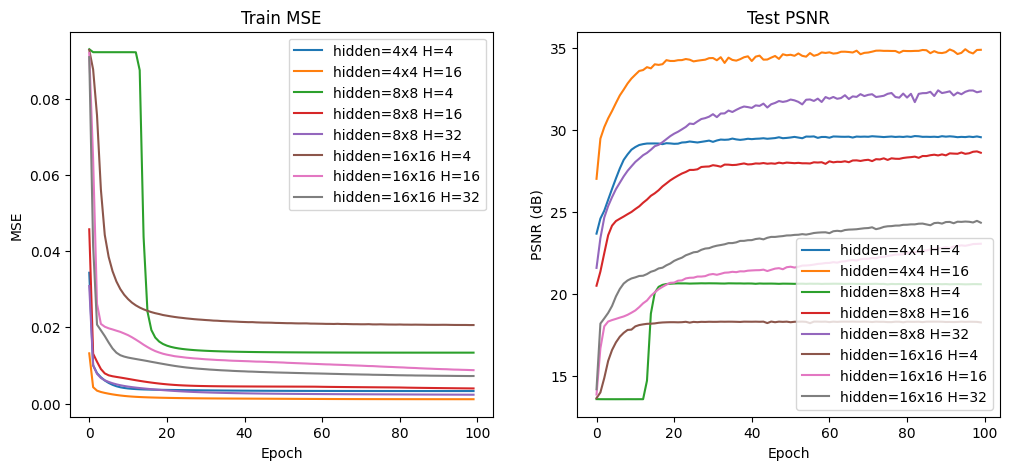


--- Plotting Momentum Comparison Curve (Test PSNR) ---


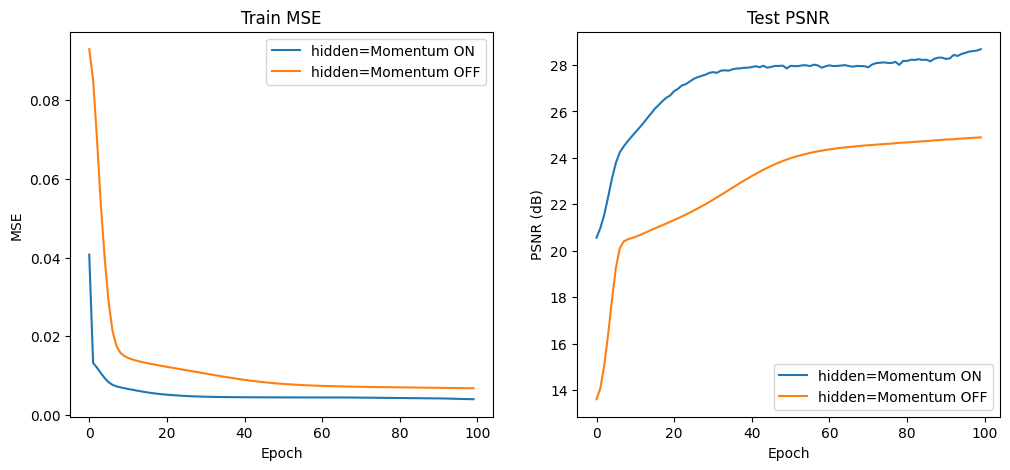


Reconstruction for BEST Model (B=8x8, H=16):

Reconstruction for WORST Model (B=16x16, H=4):

Reconstruction for Momentum ON (B=8x8):

Reconstruction for Momentum OFF (B=8x8):


In [47]:
# --- 1. Preparation (Assuming all helper functions and classes are defined) ---
# --- Block Sizes: 4, 8, 16. Hidden Dims: 4, 16, 32. ---
# --- Training Parameters ---
HIDDEN_DIMS = [4, 16, 32]
BLOCK_SIZES = [4, 8, 16]
LEARNING_RATE = 0.005 # Adjusted to a safer value for stability
EPOCHS = 100
BATCH_SIZE = 128
INPUT_IMG_SAMPLE = test_images[0] # Image for visualization

combined_results = {} # Stores all 3x3 combinations
momentum_results = {} # Stores Momentum ON/OFF comparison

# --- 2. Phase 1: 3x3 Experiments (Hidden Dim vs Block Size) ---
# (The code block from the previous turn)
for block_s in BLOCK_SIZES:
    input_dim = block_s * block_s
    train_data = prepare_data_by_block(train_images, block_s)
    test_data = prepare_data_by_block(test_images, block_s)
    
    for hid in HIDDEN_DIMS:
        if hid > input_dim:
            print(f"Skipping B={block_s}x{block_s}, H={hid}")
            continue
            
        print(f"\n[EXP] Training B={block_s}x{block_s}, H={hid} (Momentum ON)")
        model = MLP_Autoencoder_Improved(input_dim=input_dim, hidden_dim=hid, use_momentum=True)
        
        train_c, test_c = train_autoencoder_minibatch(model, train_data, test_data, epochs=EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE)
        
        combined_results[(block_s, hid)] = {
            'final_psnr': test_c[-1],
            'model': model,
            'train_curve': train_c,
            'test_curve': test_c
        }
        print(f"Final PSNR: {test_c[-1]:.2f} dB")


# --- 3. Phase 2: Momentum Comparison (B=8, H=16) ---
B_MOMENTUM, H_MOMENTUM = 8, 16
print(f"\n--- Phase 2: Momentum Comparison (B=8x8, H=16) ---")

train_data_mom = prepare_data_by_block(train_images, B_MOMENTUM)
test_data_mom = prepare_data_by_block(test_images, B_MOMENTUM)

# Momentum ON
model_on = MLP_Autoencoder_Improved(input_dim=64, hidden_dim=16, use_momentum=True, beta=0.9)
train_c_on, test_c_on = train_autoencoder_minibatch(model_on, train_data_mom, test_data_mom, epochs=EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE)
momentum_results['Momentum ON'] = (train_c_on, test_c_on)
print(f"Momentum ON Final PSNR: {test_c_on[-1]:.2f} dB")

# Momentum OFF
model_off = MLP_Autoencoder_Improved(input_dim=64, hidden_dim=16, use_momentum=False)
train_c_off, test_c_off = train_autoencoder_minibatch(model_off, train_data_mom, test_data_mom, epochs=EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE)
momentum_results['Momentum OFF'] = (train_c_off, test_c_off)
print(f"Momentum OFF Final PSNR: {test_c_off[-1]:.2f} dB")


# --- 4. Report Generation (Visualization) ---

# A. Summary Table (Comparison of all PSNR)
print("\n" + summarize_results({k: v for k, v in combined_results.items()}))

# B. Learning Curves (Rend-e Yadgiri) for all 3x3 cases
print("\n--- Plotting All 3x3 Learning Curves (Train MSE and Test PSNR) ---")
# Reformat the results for the existing plot_curves function
plot_data_3x3 = {f"{k[0]}x{k[0]} H={k[1]}": (v['train_curve'], v['test_curve']) for k, v in combined_results.items()}
plot_curves(plot_data_3x3) # Requires adaptation in plot_curves to handle dictionary of tuples

# C. Momentum Comparison Curve
print("\n--- Plotting Momentum Comparison Curve (Test PSNR) ---")
# This plot compares only the Test PSNR for ON vs OFF
plot_curves(momentum_results)


# D. Image Reconstructions (Tasaweer Bazsazi shode)
INPUT_IMG_SAMPLE = test_images[0]

# 1. Best performing model (B=8, H=16)
best_model_key = (8, 16) 
if best_model_key in combined_results:
    print(f"\nReconstruction for BEST Model (B=8x8, H=16):")
    # MODIFIED CALL: Passing block_size=8
    show_reconstruction(combined_results[best_model_key]['model'], INPUT_IMG_SAMPLE, block_size=8)

# 2. Worst performing model (B=16, H=4)
worst_model_key = (16, 4) 
if worst_model_key in combined_results:
    print(f"\nReconstruction for WORST Model (B=16x16, H=4):")
    # MODIFIED CALL: Passing block_size=16
    show_reconstruction(combined_results[worst_model_key]['model'], INPUT_IMG_SAMPLE, block_size=16)

# 3. Momentum ON vs OFF (Both use B=8)
print("\nReconstruction for Momentum ON (B=8x8):")
show_reconstruction(model_on, INPUT_IMG_SAMPLE, block_size=8)
print("\nReconstruction for Momentum OFF (B=8x8):")
show_reconstruction(model_off, INPUT_IMG_SAMPLE, block_size=8)


--- نمایش تصاویر بازسازی شده برای تمام حالات درخواستی ---

نمایش بازسازی برای Block=4x4, Hidden=4, PSNR=29.58 dB


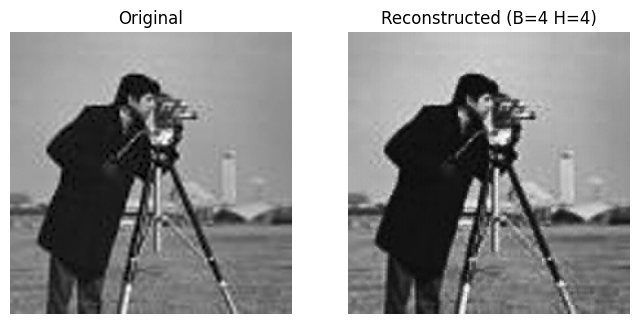


نمایش بازسازی برای Block=4x4, Hidden=16, PSNR=34.91 dB


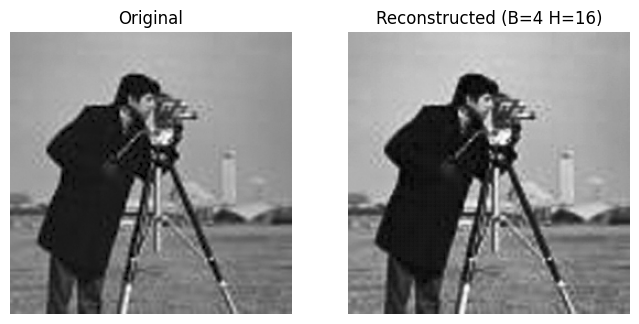


نمایش بازسازی برای Block=8x8, Hidden=4, PSNR=20.60 dB


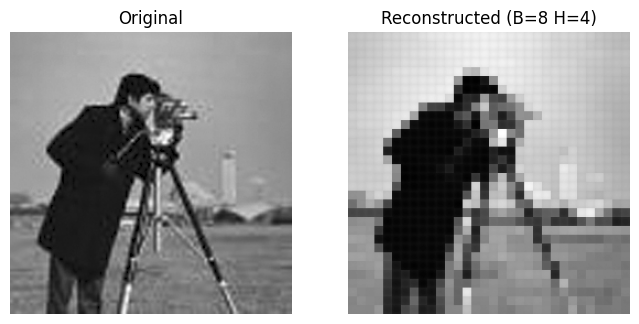


نمایش بازسازی برای Block=8x8, Hidden=16, PSNR=28.63 dB


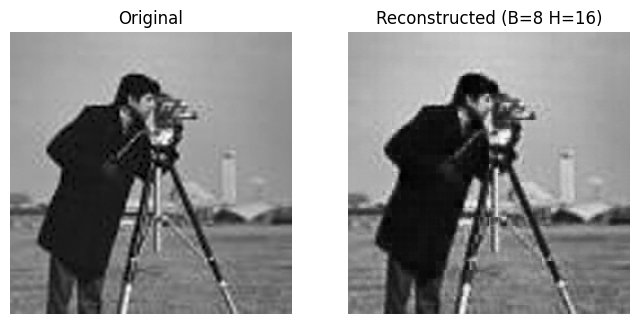


نمایش بازسازی برای Block=8x8, Hidden=32, PSNR=32.37 dB


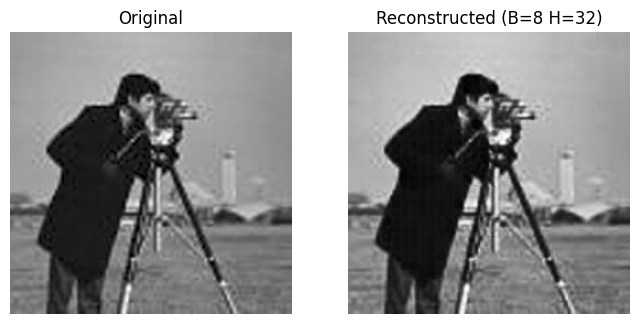


نمایش بازسازی برای Block=16x16, Hidden=4, PSNR=18.27 dB


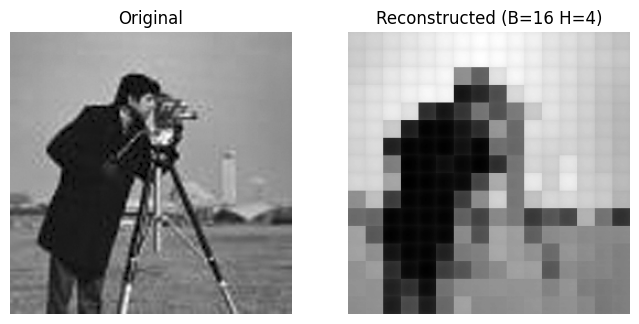


نمایش بازسازی برای Block=16x16, Hidden=16, PSNR=23.07 dB


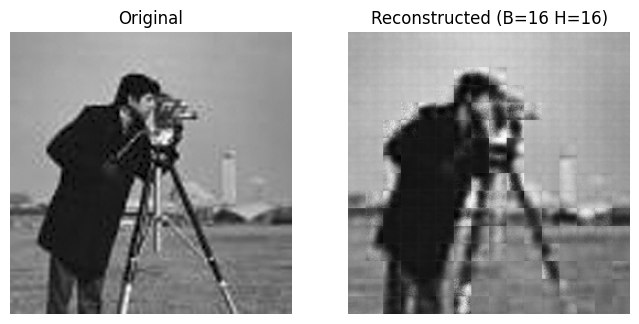


نمایش بازسازی برای Block=16x16, Hidden=32, PSNR=24.36 dB


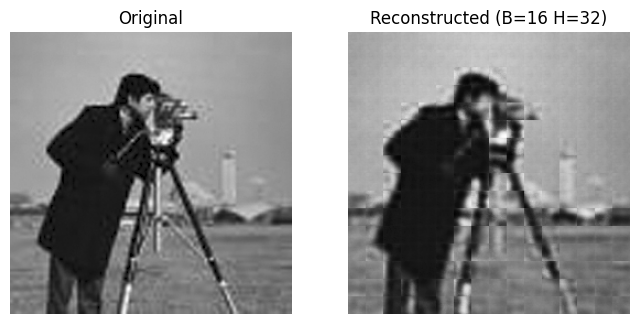


نمایش بازسازی برای Momentum ON (B=8x8, H=16)


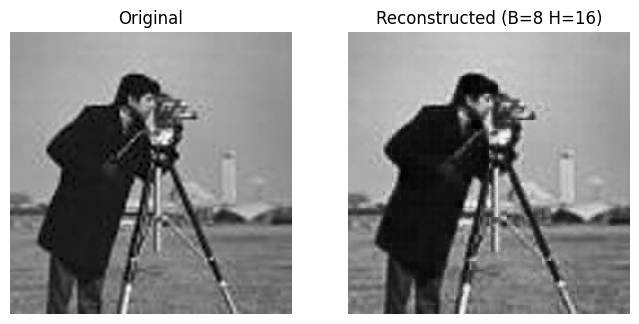


نمایش بازسازی برای Momentum OFF (B=8x8, H=16)


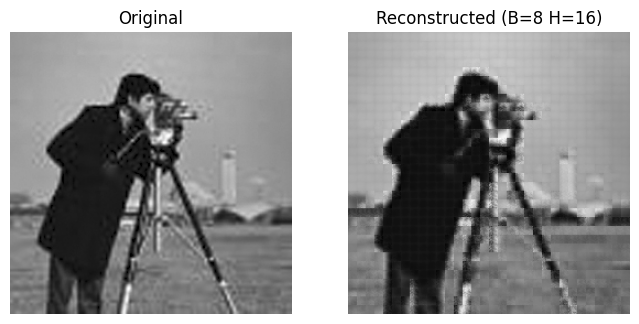

array([[154, 156, 156, ..., 152, 151, 150],
       [155, 157, 157, ..., 153, 151, 150],
       [156, 158, 159, ..., 153, 152, 150],
       ...,
       [120, 120, 119, ..., 109, 113, 114],
       [116, 119, 122, ..., 104, 107, 111],
       [119, 119, 122, ..., 106, 109, 108]], shape=(256, 256), dtype=uint8)

In [49]:
# --- Configuration & Loaded Data (Based on previous steps) ---
# HIDDEN_DIMS = [4, 16, 32]
# BLOCK_SIZES = [4, 8, 16]
# INPUT_IMG_SAMPLE = test_images[0]
# combined_results (dictionary from 3x3 loop)
# model_on, model_off (from Momentum comparison)
# -----------------------------------------------------------

print("\n--- نمایش تصاویر بازسازی شده برای تمام حالات درخواستی ---")

# A. نمایش تمام 3x3 حالت (Block Size vs Hidden Dim)
for key, data in combined_results.items():
    block_s, hid = key
    model = data['model']
    
    # نمایش تصویر
    print(f"\nنمایش بازسازی برای Block={block_s}x{block_s}, Hidden={hid}, PSNR={data['final_psnr']:.2f} dB")
    show_reconstruction(model, INPUT_IMG_SAMPLE, block_size=block_s)


# B. نمایش مقایسه گشتاور (Momentum ON vs OFF)
B_MOMENTUM, H_MOMENTUM = 8, 16

# Momentum ON
print(f"\nنمایش بازسازی برای Momentum ON (B={B_MOMENTUM}x{B_MOMENTUM}, H={H_MOMENTUM})")
show_reconstruction(model_on, INPUT_IMG_SAMPLE, block_size=B_MOMENTUM)

# Momentum OFF
print(f"\nنمایش بازسازی برای Momentum OFF (B={B_MOMENTUM}x{B_MOMENTUM}, H={H_MOMENTUM})")
show_reconstruction(model_off, INPUT_IMG_SAMPLE, block_size=B_MOMENTUM)